In [2]:
import cv2 as cv
import os
import numpy as np
import glob
import pickle
from sklearn.svm import LinearSVC
from skimage.feature import hog
import matplotlib.pyplot as plt
import ntpath



In [14]:
def get_negative_descriptors(params):
    images_path = os.path.join(params.dir_neg_examples, '*.jpg')
    files = glob.glob(images_path)
    num_images = len(files)
    negative_descriptors = []
    print(f'Calculeaza descriptori pozitivi din img {num_images} ...')

    for i in range(num_images):
        print(f'Se proceseaza imaginea nonface  cu numarul {i}...')
        img = cv.imread(files[i], cv.IMREAD_GRAYSCALE)
        img_resized = cv.resize(img, (36, 36))  
        features = hog(img_resized, pixels_per_cell=(params.dim_hog_cell, params.dim_hog_cell),
                       cells_per_block=(2, 2), feature_vector=True)
        negative_descriptors.append(features)

        if params.use_flip_images:
            flipped_img = np.fliplr(img_resized)
            features_flipped = hog(flipped_img, pixels_per_cell=(params.dim_hog_cell, params.dim_hog_cell),
                                   cells_per_block=(2, 2), feature_vector=True)
            negative_descriptors.append(features_flipped)

    return np.array(negative_descriptors)

In [15]:
def get_positive_descriptors(params):
    images_path = os.path.join(params.dir_pos_examples, '*.jpg')
    files = glob.glob(images_path)
    num_images = len(files)
    positive_descriptors = []
    print(f'Calculeaza descriptori pozitivi din img {num_images} ...')

    for i in range(num_images):
        print(f'Se proceseaza imaginea face {i}...')
        img = cv.imread(files[i], cv.IMREAD_GRAYSCALE)
        img_resized = cv.resize(img, (36, 36))  
        features = hog(img_resized, pixels_per_cell=(params.dim_hog_cell, params.dim_hog_cell),
                       cells_per_block=(2, 2), feature_vector=True)
        positive_descriptors.append(features)

        if params.use_flip_images:
            flipped_img = np.fliplr(img_resized)
            features_flipped = hog(flipped_img, pixels_per_cell=(params.dim_hog_cell, params.dim_hog_cell),
                                   cells_per_block=(2, 2), feature_vector=True)
            positive_descriptors.append(features_flipped)

    return np.array(positive_descriptors)

In [5]:
def prepare_data(pos_descriptors, neg_descriptors):
   
    training_examples = np.concatenate([pos_descriptors, neg_descriptors], axis=0)
   
    pos_labels = np.ones(len(pos_descriptors))
    neg_labels = np.zeros(len(neg_descriptors))

    train_labels = np.concatenate([pos_labels, neg_labels])
    print(train_labels)
    return training_examples, train_labels

def train_classifier(training_examples, train_labels, params):
    svm_file_name = 'best_model.sav'  
    if os.path.exists(svm_file_name):
        print('Incarcare model')
        return pickle.load(open(svm_file_name, 'rb'))

    best_accuracy = 0
    best_c = 0
    best_model = None
    Cs = [10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 10**0]

    for c in Cs:
        print(f'Se antreneaza pentru c={c}')
        model = LinearSVC(C=c)
        model.fit(training_examples, train_labels)  
        acc = model.score(training_examples, train_labels)
        print(f'Acuratete: {acc}')
        if acc > best_accuracy:
            best_accuracy = acc
            best_c = c
            best_model = model

    print(f'Best classifier performance for c = {best_c}')
    pickle.dump(best_model, open(svm_file_name, 'wb'))
    return best_model



In [6]:
def intersection_over_union(bbox_a, bbox_b):
   
   
    x_a = max(bbox_a[0], bbox_b[0])
    y_a = max(bbox_a[1], bbox_b[1])
    x_b = min(bbox_a[2], bbox_b[2])
    y_b = min(bbox_a[3], bbox_b[3])

    
    inter_area = max(0, x_b - x_a + 1) * max(0, y_b - y_a + 1)

   
    bbox_a_area = (bbox_a[2] - bbox_a[0] + 1) * (bbox_a[3] - bbox_a[1] + 1)
    bbox_b_area = (bbox_b[2] - bbox_b[0] + 1) * (bbox_b[3] - bbox_b[1] + 1)

   
    iou = inter_area / float(bbox_a_area + bbox_b_area - inter_area)

   
    scale_a = max(bbox_a[2] - bbox_a[0] + 1, bbox_a[3] - bbox_a[1] + 1)
    scale_b = max(bbox_b[2] - bbox_b[0] + 1, bbox_b[3] - bbox_b[1] + 1)
    scale_ratio = min(scale_a, scale_b) / max(scale_a, scale_b)

    
    adjusted_iou = iou * scale_ratio
    return adjusted_iou

In [7]:
def non_maximal_suppression(image_detections, image_scores, image_size):
    sorted_indices = np.argsort(image_scores)[::-1]
    sorted_image_detections = image_detections[sorted_indices]
    sorted_scores = image_scores[sorted_indices]

    is_maximal = np.ones(len(sorted_image_detections), dtype=bool)

    iou_threshold = 0.3
    for i in range(len(sorted_image_detections) - 1):
        if not is_maximal[i]:
            continue
        for j in range(i + 1, len(sorted_image_detections)):
            if is_maximal[j]:
                iou = intersection_over_union(sorted_image_detections[i], sorted_image_detections[j])
                if iou > iou_threshold:
                    is_maximal[j] = False

    return sorted_image_detections[is_maximal], sorted_scores[is_maximal]

In [39]:
def run(params, model):
        test_images_path = os.path.join(params.dir_test_examples, '*.jpg')
        test_files = glob.glob(test_images_path)
        detections = None
        scores = np.array([]) 
        file_names = np.array([])  
        w = model.coef_.T
        bias = model.intercept_[0]
        num_test_images = len(test_files)
        descriptors_to_return = []
        scales = np.linspace(0.5, 1, 5) 
        window_sizes = [(100, 130), (120, 170),(100, 90), (80,80),(200,250) ]  

        for i in range(num_test_images):
            start_time = time.time()
            print(f'Timp de procesare  {i+1}/{num_test_images}...')
            img = cv.imread(test_files[i], cv.IMREAD_GRAYSCALE)
            image_scores = []
            image_detections = []

            for scale in scales:
                scaled_img = cv.resize(img, (0, 0), fx=scale, fy=scale)
                num_cols = scaled_img.shape[1] // params.dim_hog_cell - 1
                num_rows = scaled_img.shape[0] // params.dim_hog_cell - 1

                for window_height, window_width in window_sizes:
                    num_cell_in_template_x = window_width // params.dim_hog_cell - 1
                    num_cell_in_template_y = window_height // params.dim_hog_cell - 1

                    for y in range(0, num_rows - num_cell_in_template_y):
                        for x in range(0, num_cols - num_cell_in_template_x):
                            

                            resized_window = cv.resize(scaled_img[y * params.dim_hog_cell:(y + num_cell_in_template_y) * params.dim_hog_cell,
                                                                x * params.dim_hog_cell:(x + num_cell_in_template_x) * params.dim_hog_cell],
                                                    (36, 36))  

                            resized_descr = hog(resized_window, pixels_per_cell=(params.dim_hog_cell, params.dim_hog_cell),
                                                cells_per_block=(2, 2), feature_vector=True)

                            if resized_descr.shape[0] != w.shape[0]:
                                print(f"Feature  mismatch: {resized_descr.shape[0]} != {w.shape[0]} Skip.")
                                continue

                            score = np.dot(resized_descr, w)[0] + bias
                            if score > params.threshold:
                                x_min = int(x *params.dim_hog_cell)
                                y_min = int(y * params.dim_hog_cell)
                                x_max = int(x * params.dim_hog_cell + window_width)
                                y_max = int(y * params.dim_hog_cell + window_height)
                                image_detections.append([x_min, y_min, x_max, y_max])
                                image_scores.append(score)

            if len(image_scores) > 0:
                image_detections, image_scores = non_maximal_suppression(np.array(image_detections),
                                                                            np.array(image_scores), img.shape)
            if len(image_scores) > 0:
                if detections is None:
                    detections = image_detections
                else:
                    detections = np.concatenate((detections, image_detections))
                scores = np.append(scores, image_scores)
                short_name = ntpath.basename(test_files[i])
                image_names = [short_name for ww in range(len(image_scores))]
                file_names = np.append(file_names, image_names)

            end_time = time.time()
            print(f'Timp de procesare {i+1}/{num_test_images}: {end_time - start_time:.3f} sec')

        return detections, scores, file_names


In [9]:
import os
import cv2 as cv

def save_false_positive(detection_idx, detection, file_name, params):
  
    
    save_folder = "C:/Users/alexn/Downloads/cava_tema_2/hard_mined_eval/"
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)

   
    image_path = os.path.join(params.dir_test_examples, file_name)
    img = cv.imread(image_path)
    if img is None:
        print(f"Nu se poate salva imaginea la  {image_path}")
        return

  
    x_min, y_min, x_max, y_max = detection
    cropped_detection = img[y_min:y_max, x_min:x_max]

  
    save_path = os.path.join(save_folder, f"fp3_{detection_idx}.jpg")
    cv.imwrite(save_path, cropped_detection)
    print(f"Salvata false positive: {save_path}")


In [44]:

def show_detections_without_ground_truth(detections, scores, file_names, params: Parameters):
    test_images_path = os.path.join(params.dir_test_examples, '*.jpg')
    test_files = glob.glob(test_images_path)

    for test_file in test_files:
        image = cv.imread(test_file)
        short_file_name = ntpath.basename(test_file)
        indices_detections_current_image = np.where(file_names == short_file_name)
        current_detections = detections[indices_detections_current_image]
        current_scores = scores[indices_detections_current_image]

        for idx, detection in enumerate(current_detections):
            cv.rectangle(image, (detection[0], detection[1]), (detection[2], detection[3]), (0, 0, 255), thickness=1)
            cv.putText(image, 'score:' + str(current_scores[idx])[:4], (detection[0], detection[1]),
                       cv.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
        cv.imwrite(os.path.join(params.dir_save_files, "detections_" + short_file_name), image)
        cv.imshow('image', np.uint8(image))
        cv.waitKey(0)


In [49]:
import numpy as np
import pickle
import os


class Parameters:
    def __init__(self):
        self.dir_test_examples = 'C:/Users/alexn/Downloads/cava_tema_2/validare/validare_20/'#'C:/Users/alexn/Downloads/cava_tema_2/validare/validare_20/' "C:/Users/alexn/Downloads/cava_tema_2/antrenare/dad/
        self.dir_pos_examples = 'C:/Users/alexn/Downloads/cava_tema_2/cropped_faces_64x64_v2/faces/'
        self.dir_neg_examples = 'C:/Users/alexn/Downloads/cava_tema_2/no_faces_64x64_v3/'
        self.dir_save_files = 'C:/Users/alexn/OneDrive/Desktop/CAVA_2/coduri_noi/Cod_predare/'
        self.dim_hog_cell = 6
        self.dim_window = 36
        self.threshold = 0
        self.use_flip_images = True


params = Parameters()




def load_model(model_path):
    
    if os.path.exists(model_path):
        with open(model_path, 'rb') as file:
            model = pickle.load(file)
            return model
    else:
        raise FileNotFoundError(f"Nu s-a gasit modelul la {model_path}")






In [74]:
#NU SE TESTEAZA
model_path = os.path.join(params.dir_save_files, 'best_model.sav')


directory = os.path.dirname(model_path)

if not os.path.exists(directory):
    os.makedirs(directory)
if model is None:
        pass
else:
   
    pos_descriptors = get_positive_descriptors(params)
    neg_descriptors = get_negative_descriptors(params)
    print("Shape of positive descriptors:", pos_descriptors.shape)
    print("Shape of negative descriptors:", neg_descriptors.shape)
    training_examples, train_labels = prepare_data(pos_descriptors, neg_descriptors)


Calculeaza descriptori pozitivi din img 5813 ...
Se proceseaza imaginea non-face 0...
Se proceseaza imaginea non-face 1...
Se proceseaza imaginea non-face 2...
Se proceseaza imaginea non-face 3...
Se proceseaza imaginea non-face 4...
Se proceseaza imaginea non-face 5...
Se proceseaza imaginea non-face 6...
Se proceseaza imaginea non-face 7...
Se proceseaza imaginea non-face 8...
Se proceseaza imaginea non-face 9...
Se proceseaza imaginea non-face 10...
Se proceseaza imaginea non-face 11...
Se proceseaza imaginea non-face 12...
Se proceseaza imaginea non-face 13...
Se proceseaza imaginea non-face 14...
Se proceseaza imaginea non-face 15...
Se proceseaza imaginea non-face 16...
Se proceseaza imaginea non-face 17...
Se proceseaza imaginea non-face 18...
Se proceseaza imaginea non-face 19...
Se proceseaza imaginea non-face 20...
Se proceseaza imaginea non-face 21...
Se proceseaza imaginea non-face 22...
Se proceseaza imaginea non-face 23...
Se proceseaza imaginea non-face 24...
Se procesea

In [73]:
#NU SE RULEAZA LA TESTARE 
training_examples, train_labels = prepare_data(pos_descriptors, neg_descriptors)
model = train_classifier(training_examples, train_labels, params)

with open(model_path, 'wb') as file:
 pickle.dump(model, file)



[1. 1. 1. ... 0. 0. 0.]
Incarcare model


In [48]:
import time

detections, scores, file_names = run(params, model)


Timp de procesare  1/200...
Timp de procesare 1/200: 17.828 sec
Timp de procesare  2/200...
Timp de procesare 2/200: 18.753 sec
Timp de procesare  3/200...
Timp de procesare 3/200: 19.383 sec
Timp de procesare  4/200...
Timp de procesare 4/200: 19.523 sec
Timp de procesare  5/200...
Timp de procesare 5/200: 18.641 sec
Timp de procesare  6/200...
Timp de procesare 6/200: 19.203 sec
Timp de procesare  7/200...
Timp de procesare 7/200: 19.054 sec
Timp de procesare  8/200...
Timp de procesare 8/200: 18.981 sec
Timp de procesare  9/200...
Timp de procesare 9/200: 17.631 sec
Timp de procesare  10/200...
Timp de procesare 10/200: 19.485 sec
Timp de procesare  11/200...
Timp de procesare 11/200: 21.904 sec
Timp de procesare  12/200...
Timp de procesare 12/200: 21.265 sec
Timp de procesare  13/200...
Timp de procesare 13/200: 18.295 sec
Timp de procesare  14/200...
Timp de procesare 14/200: 17.725 sec
Timp de procesare  15/200...
Timp de procesare 15/200: 19.450 sec
Timp de procesare  16/200...

KeyboardInterrupt: 

In [43]:
save_path = "C:/Users/alexn/OneDrive/Desktop/CAVA_2/coduri_noi/coduri_finale/test/task1" #"C:/Users/alexn/OneDrive/Desktop/CAVA_2/coduri_noi/coduri_finale/test/task1/"

if not os.path.exists(save_path):
    os.makedirs(save_path)


if not os.path.exists(save_path):
    os.makedirs(save_path)


np.save(os.path.join(save_path, "detections.npy"), detections)
np.save(os.path.join(save_path, "scores.npy"), scores)
np.save(os.path.join(save_path, "file_names.npy"), file_names)

print("Fisiere salvate")

Fisiere salvate


In [ ]:
#NU SE RULEAZA LA TESTARE
show_detections_without_ground_truth(detections, scores, file_names, params)



(657, 4)
(657,)
(657,)
Saved false positive: C:/Users/alexn/Downloads/cava_tema_2/hard_mined_eval/fp3_6.jpg
Saved false positive: C:/Users/alexn/Downloads/cava_tema_2/hard_mined_eval/fp3_14.jpg
Saved false positive: C:/Users/alexn/Downloads/cava_tema_2/hard_mined_eval/fp3_16.jpg
Saved false positive: C:/Users/alexn/Downloads/cava_tema_2/hard_mined_eval/fp3_18.jpg
Saved false positive: C:/Users/alexn/Downloads/cava_tema_2/hard_mined_eval/fp3_23.jpg
Saved false positive: C:/Users/alexn/Downloads/cava_tema_2/hard_mined_eval/fp3_24.jpg
Saved false positive: C:/Users/alexn/Downloads/cava_tema_2/hard_mined_eval/fp3_25.jpg
Saved false positive: C:/Users/alexn/Downloads/cava_tema_2/hard_mined_eval/fp3_26.jpg
Saved false positive: C:/Users/alexn/Downloads/cava_tema_2/hard_mined_eval/fp3_27.jpg
Saved false positive: C:/Users/alexn/Downloads/cava_tema_2/hard_mined_eval/fp3_31.jpg
Saved false positive: C:/Users/alexn/Downloads/cava_tema_2/hard_mined_eval/fp3_32.jpg
Saved false positive: C:/Users/a

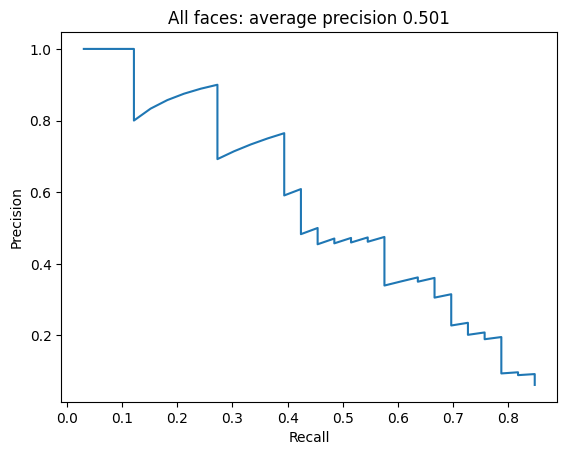

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pdb

#NU SE RULEAZA LA TESTARE 


def compute_average_precision(rec, prec):
    # functie adaptata din 2010 Pascal VOC development kit
    m_rec = np.concatenate(([0], rec, [1]))
    m_pre = np.concatenate(([0], prec, [0]))
    for i in range(len(m_pre) -  1, -1, 1):
        m_pre[i] = max(m_pre[i], m_pre[i + 1])
    m_rec = np.array(m_rec)
    i = np.where(m_rec[1:] != m_rec[:-1])[0] + 1
    average_precision = np.sum((m_rec[i] - m_rec[i - 1]) * m_pre[i])
    return average_precision


def eval_detections(detections, scores, file_names, ground_truth_path):
   
    ground_truth_file = np.loadtxt(ground_truth_path, dtype='str')
    ground_truth_file_names = np.array(ground_truth_file[:, 0])
    ground_truth_detections = np.array(ground_truth_file[:, 1:], dtype=int)

    num_gt_detections = len(ground_truth_detections)  # numar total de adevarat pozitive
    gt_exists_detection = np.zeros(num_gt_detections)
    # sorteazam detectiile dupa scorul lor
    sorted_indices = np.argsort(scores)[::-1]
    file_names = file_names[sorted_indices]
    scores = scores[sorted_indices]
    detections = detections[sorted_indices]

    num_detections = len(detections)
    true_positive = np.zeros(num_detections)
    false_positive = np.zeros(num_detections)
    duplicated_detections = np.zeros(num_detections)

    for detection_idx in range(num_detections):
        indices_detections_on_image = np.where(ground_truth_file_names == file_names[detection_idx])[0]

        gt_detections_on_image = ground_truth_detections[indices_detections_on_image]
        bbox = detections[detection_idx]
        max_overlap = -1
        index_max_overlap_bbox = -1
        for gt_idx, gt_bbox in enumerate(gt_detections_on_image):
            overlap = intersection_over_union(bbox, gt_bbox)
            
            if overlap > max_overlap:
                max_overlap = overlap
                index_max_overlap_bbox = indices_detections_on_image[gt_idx]
                
        # clasifica o detectie ca fiind adevarat pozitiva / fals pozitiva
        if max_overlap >= 0.3:
            if gt_exists_detection[index_max_overlap_bbox] == 0:
                
                true_positive[detection_idx] = 1
                gt_exists_detection[index_max_overlap_bbox] = 1
            else:
                
                duplicated_detections[detection_idx] = 1
        elif max_overlap < 0.1:
            
            false_positive[detection_idx] = 1
            save_false_positive(detection_idx, detections[detection_idx], file_names[detection_idx], params)


    cum_false_positive = np.cumsum(false_positive)
    cum_true_positive = np.cumsum(true_positive)

    rec = cum_true_positive / num_gt_detections
    prec = cum_true_positive / (cum_true_positive + cum_false_positive)
    average_precision = compute_average_precision(rec, prec)
    plt.plot(rec, prec, '-')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('All faces: average precision %.3f' % average_precision)
    plt.savefig('precizie_medie_all_faces.png')
    plt.show()

def eval_detections_character(detections, scores, file_names,ground_truth_path,character):
    ground_truth_file = np.loadtxt(ground_truth_path, dtype='str')
    ground_truth_file_names = np.array(ground_truth_file[:, 0])
    ground_truth_detections = np.array(ground_truth_file[:, 1:], dtype=int)

    num_gt_detections = len(ground_truth_detections)  # numar total de adevarat pozitive
    gt_exists_detection = np.zeros(num_gt_detections)
    # sorteazam detectiile dupa scorul lor
    sorted_indices = np.argsort(scores)[::-1]
    file_names = file_names[sorted_indices]
    scores = scores[sorted_indices]
    detections = detections[sorted_indices]

    num_detections = len(detections)
    true_positive = np.zeros(num_detections)
    false_positive = np.zeros(num_detections)
    duplicated_detections = np.zeros(num_detections)

    for detection_idx in range(num_detections):
        indices_detections_on_image = np.where(ground_truth_file_names == file_names[detection_idx])[0]

        gt_detections_on_image = ground_truth_detections[indices_detections_on_image]
        bbox = detections[detection_idx]
        max_overlap = -1
        index_max_overlap_bbox = -1
        for gt_idx, gt_bbox in enumerate(gt_detections_on_image):
            overlap = intersection_over_union(bbox, gt_bbox)
            if overlap > max_overlap:
                max_overlap = overlap
                index_max_overlap_bbox = indices_detections_on_image[gt_idx]

        # clasifica o detectie ca fiind adevarat pozitiva / fals pozitiva
        if max_overlap >= 0.3:
            if gt_exists_detection[index_max_overlap_bbox] == 0:
                true_positive[detection_idx] = 1
                gt_exists_detection[index_max_overlap_bbox] = 1
            else:
                false_positive[detection_idx] = 1
                duplicated_detections[detection_idx] = 1
                
                
        else:
            false_positive[detection_idx] = 1

    cum_false_positive = np.cumsum(false_positive)
    cum_true_positive = np.cumsum(true_positive)

    rec = cum_true_positive / num_gt_detections
    prec = cum_true_positive / (cum_true_positive + cum_false_positive)
    average_precision = compute_average_precision(rec, prec)
    plt.plot(rec, prec, '-')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(character + ' faces: average precision %.3f' % average_precision)
    plt.savefig('precizie_medie_' + character + '.png')
    plt.show()

def evaluate_results_task1(solution_path,ground_truth_path,verbose = 0):

	#incarca detectiile + scorurile + numele de imagini	
	detections = np.load(solution_path + "detections.npy",allow_pickle=True,fix_imports=True,encoding='latin1')
	print(detections.shape)

	scores = np.load(solution_path + "scores.npy",allow_pickle=True,fix_imports=True,encoding='latin1')
	print(scores.shape)
	
	file_names = np.load(solution_path + "file_names.npy",allow_pickle=True,fix_imports=True,encoding='latin1')
	print(file_names.shape)

	eval_detections(detections, scores, file_names, ground_truth_path)

def evaluate_results_task2(solution_path,ground_truth_path,character, verbose = 0):

	#incarca detectiile + scorurile + numele de imagini	
	detections = np.load(solution_path + "detections_" + character + ".npy",allow_pickle=True,fix_imports=True,encoding='latin1')
	print(detections.shape)

	scores = np.load(solution_path + "scores_"+ character + ".npy",allow_pickle=True,fix_imports=True,encoding='latin1')
	print(scores.shape)
	
	file_names = np.load(solution_path + "file_names_"+ character + ".npy",allow_pickle=True,fix_imports=True,encoding='latin1')
	print(file_names.shape)

	eval_detections_character(detections, scores, file_names, ground_truth_path, character)
  
verbose = 0

#change this on your machine
solution_path_root = "C:/Users/alexn/OneDrive/Desktop/CAVA_2/coduri_noi/coduri_finale/test/"
ground_truth_path_root = "C:/Users/alexn/Downloads/cava_tema_2/validare/"

#task1
solution_path = solution_path_root + "task1/"
ground_truth_path = ground_truth_path_root + "task1_gt_validare20.txt"
evaluate_results_task1(solution_path, ground_truth_path, verbose)


#task2
#solution_path = solution_path_root + "task2/"


#evaluate_results_task2(solution_path, ground_truth_path, "dad", verbose)

#ground_truth_path = ground_truth_path_root + "task2_mom_gt_validare20.txt"
#evaluate_results_task2(solution_path, ground_truth_path, "mom", verbose)

#ground_truth_path = ground_truth_path_root + "task2_dexter_gt_validare20.txt"
#evaluate_results_task2(solution_path, ground_truth_path, "dexter", verbose)

#ground_truth_path = ground_truth_path_root + "task2_deedee_gt_validare20.txt"
#evaluate_results_task2(solution_path, ground_truth_path, "deedee", verbose)